In [1]:
# Cell 1: Imports and Setup

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
from tqdm import tqdm
import warnings

# Configure plot styles
plt.style.use('seaborn-v0_8-whitegrid')
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [3]:
import os

# Mount Google Drive if using Colab
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    pass  # Skip mounting if not using Colab

# Define full paths directly
raw_path = '709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF'
segmented_path = '709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented'

# Dataset parameters
NUM_IMAGES = 887

# Print paths for confirmation
print(f"✅ Raw data path set to: {raw_path}")
print(f"✅ Segmented data path set to: {segmented_path}")

✅ Raw data path set to: 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF
✅ Segmented data path set to: 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented


In [4]:
# Cell 3: Image Loading Function

def load_image_stack(folder_path, name_template, num_images):
    """
    Loads a sequence of TIFF images into a 3D NumPy array.

    Args:
        folder_path (str): The path to the directory containing the images.
        name_template (str): A string template for the filenames, using '{i}' as a placeholder
                             for the image number (e.g., "image_Z{i:05d}.tif").
        num_images (int): The total number of images to load.

    Returns:
        np.ndarray: A 3D NumPy array of shape (num_images, height, width).
    """
    image_stack = []
    print(f"Loading {num_images} images from {os.path.basename(folder_path)}...")

    for i in tqdm(range(1, num_images + 1)):
        filename = name_template.format(i=i)
        file_path = os.path.join(folder_path, filename)

        try:
            with Image.open(file_path) as img:
                image_stack.append(np.array(img))
        except FileNotFoundError:
            print(f"Warning: File not found at {file_path}. Skipping.")
            continue

    if not image_stack:
        raise ValueError("No images were loaded. Check paths and filenames.")

    return np.stack(image_stack, axis=0)

# --- Define filename templates based on your `dir` output ---
raw_template = "709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMFZ{i:05d}.tif"
segmented_template = "709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMFZ{i:05d}_Simple Segmentation.tif"


# --- Load the datasets ---
raw_images = load_image_stack(raw_path, raw_template, NUM_IMAGES)
segmented_images = load_image_stack(segmented_path, segmented_template, NUM_IMAGES)

print("\nData loading complete!")

Loading 887 images from 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF...


  0%|          | 0/887 [00:00<?, ?it/s]

Loading 887 images from 709 h_0.4_160kV_HE6_2s_Bin2_11um_3201proj_recon_ccropped_NLMF_Segmented...


  0%|          | 0/887 [00:00<?, ?it/s]


Data loading complete!


In [4]:
# Cell 4: Basic Data Inspection

def inspect_data(data, name):
    """Prints key properties of the image stack."""
    print(f"--- Inspection for: {name} ---")
    print(f"Shape (Slices, Height, Width): {data.shape}")
    print(f"Data Type: {data.dtype}")
    # Calculate memory in MB
    memory_mb = data.nbytes / (1024 * 1024)
    print(f"Memory Usage: {memory_mb:.2f} MB")
    print(f"Pixel value range: Min={data.min()}, Max={data.max()}\n")

inspect_data(raw_images, "Raw CT Scans")
inspect_data(segmented_images, "Segmented Porosity Maps")

--- Inspection for: Raw CT Scans ---
Shape (Slices, Height, Width): (887, 1024, 996)
Data Type: uint16
Memory Usage: 1725.49 MB
Pixel value range: Min=0, Max=54108

--- Inspection for: Segmented Porosity Maps ---
Shape (Slices, Height, Width): (887, 1024, 996)
Data Type: uint8
Memory Usage: 862.75 MB
Pixel value range: Min=1, Max=2



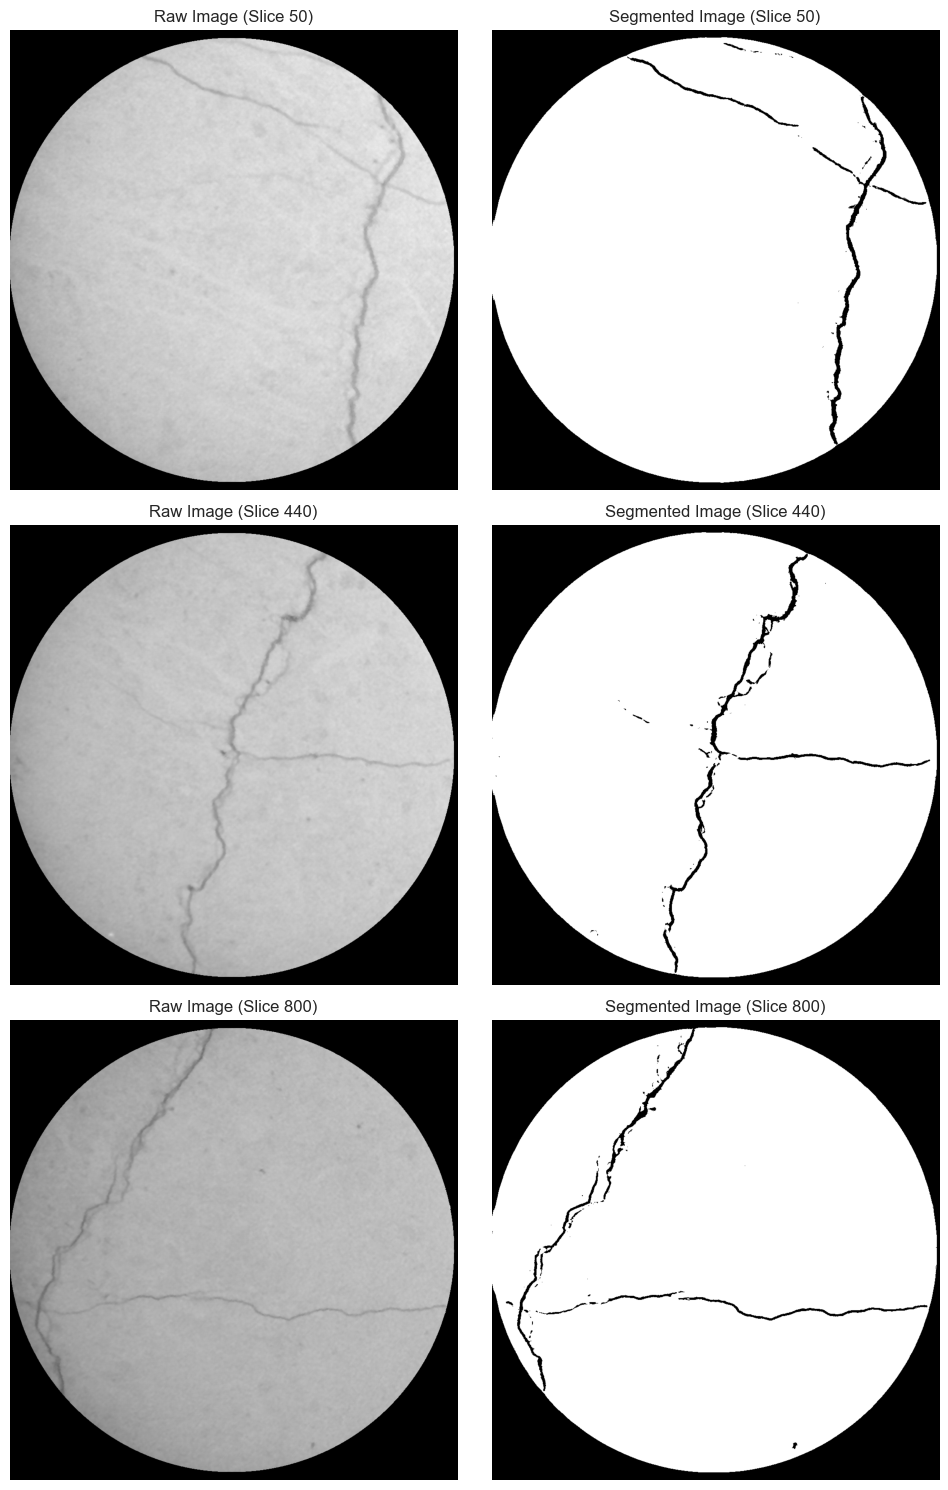

In [5]:
# Cell 5: Visualize 2D Image Slices

def show_slices(raw_stack, segmented_stack, slice_indices):
    """Displays corresponding raw and segmented slices side-by-side."""
    num_slices = len(slice_indices)
    fig, axes = plt.subplots(num_slices, 2, figsize=(10, 5 * num_slices))

    # Adjust for single slice case
    if num_slices == 1:
        axes = np.array([axes])

    for i, slice_idx in enumerate(slice_indices):
        # Raw Image
        axes[i, 0].imshow(raw_stack[slice_idx], cmap='gray')
        axes[i, 0].set_title(f'Raw Image (Slice {slice_idx})')
        axes[i, 0].axis('off')

        # Segmented Image
        axes[i, 1].imshow(segmented_stack[slice_idx], cmap='gray')
        axes[i, 1].set_title(f'Segmented Image (Slice {slice_idx})')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# --- Select some slices to display (e.g., start, middle, end) ---
slices_to_show = [50, 440, 800]
show_slices(raw_images, segmented_images, slices_to_show)

Overall Average Porosity (Φ): 0.2542 or 25.42%


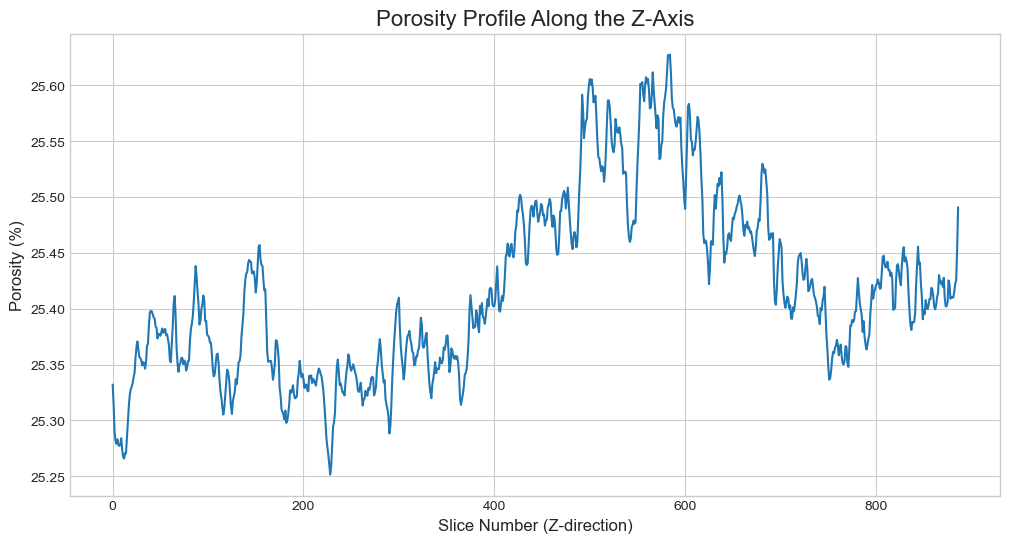

In [6]:
# Cell 6: Calculate and Plot Porosity

# Assuming pores are represented by non-zero pixels in the segmented images.
# If pores are 0, use `segmented_images == 0`.
total_pixels_per_slice = segmented_images.shape[1] * segmented_images.shape[2]
pore_pixels_per_slice = np.sum(segmented_images == 1 , axis=(1, 2))

# Calculate porosity for each slice
porosity_per_slice = pore_pixels_per_slice / total_pixels_per_slice

# Calculate the overall average porosity
overall_porosity = np.mean(porosity_per_slice)

print(f"Overall Average Porosity (Φ): {overall_porosity:.4f} or {overall_porosity*100:.2f}%")

# --- Plot porosity vs. Z-slice ---
plt.figure(figsize=(12, 6))
plt.plot(range(NUM_IMAGES), porosity_per_slice * 100)
plt.title('Porosity Profile Along the Z-Axis', fontsize=16)
plt.xlabel('Slice Number (Z-direction)', fontsize=12)
plt.ylabel('Porosity (%)', fontsize=12)
plt.grid(True)
plt.show()

Slice 443 Pixel Distribution:
  Value 1: 260038 pixels (25.50%)
  Value 2: 759866 pixels (74.50%)


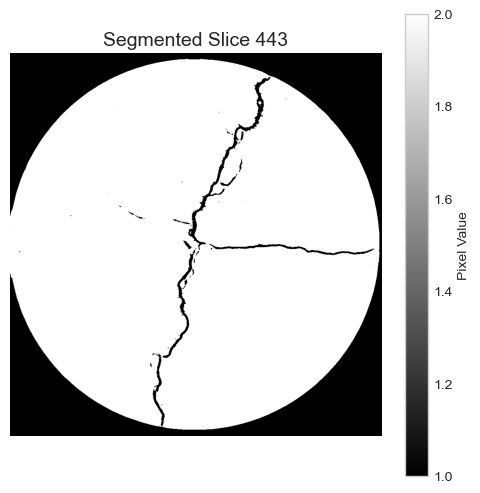

In [7]:
# Choose a slice index to inspect (e.g., middle slice)
slice_index = NUM_IMAGES // 2
slice_image = segmented_images[slice_index]

# Count pixel values
unique, counts = np.unique(slice_image, return_counts=True)
pixel_stats = dict(zip(unique, counts))

# Total pixels in the slice
total_pixels = slice_image.size

# Print pixel distribution and percentages
print(f"Slice {slice_index} Pixel Distribution:")
for value, count in pixel_stats.items():
    percentage = (count / total_pixels) * 100
    print(f"  Value {value}: {count} pixels ({percentage:.2f}%)")

# --- Visualize the slice ---
plt.figure(figsize=(6, 6))
plt.imshow(slice_image, cmap='gray')
plt.title(f'Segmented Slice {slice_index}', fontsize=14)
plt.axis('off')
plt.colorbar(label='Pixel Value')
plt.show()

Preparing 3D visualization... This may take a moment.


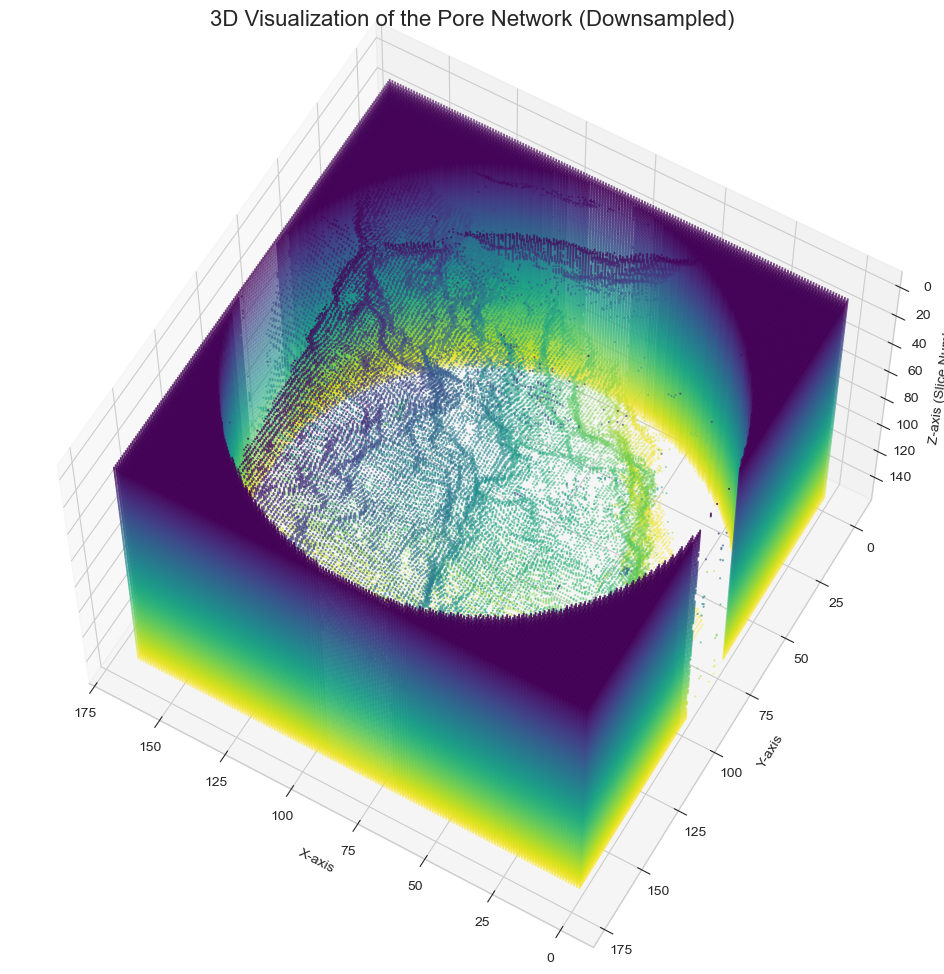

In [8]:
# Cell 7: 3D Visualization of Pore Space

print("Preparing 3D visualization... This may take a moment.")

# --- Downsample the data to make plotting feasible ---
# A factor of 4 means we take every 4th pixel in each dimension.
# Adjust this factor based on your system's performance.
downsample_factor = 6
segmented_downsampled = segmented_images[::downsample_factor, ::downsample_factor, ::downsample_factor]

# Get the coordinates of the pore pixels (where pixel value > 0)
z, y, x = np.where(segmented_downsampled == 1)

# --- Create the 3D Scatter Plot ---
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot the pore coordinates
ax.scatter(x, y, z, s=1, c=z, cmap='viridis', marker='.')

ax.set_title('3D Visualization of the Pore Network (Downsampled)', fontsize=16)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis (Slice Number)')

# Invert Z-axis so slice 0 is at the top, like a stack
ax.invert_zaxis()
ax.view_init(elev=60, azim=120)

plt.show()

In [20]:
pip install Vedo

Note: you may need to restart the kernel to use updated packages.


In [9]:
from vedo import Volume, show, Plotter
import numpy as np

# Create volume from segmented images
pore_volume = Volume(segmented_images)

# Define threshold value for isosurface
threshold_value = np.mean(segmented_images)

# Generate isosurface mesh and apply visual properties
pore_mesh = (
    pore_volume.isosurface(threshold_value)
    .c('cyan')
    .opacity(0.8)
    .lighting('plastic')           # Apply lighting model
)

# Create Plotter in offscreen mode
plotter = Plotter(offscreen=True)

# Add mesh and render
plotter.show(pore_mesh, axes=1, viewup='z', interactive=False)

# Save screenshot
plotter.screenshot("pore_network.png")

# Close the plotter
plotter.close()

In [10]:
from vedo import Volume, show, Plotter, settings
import numpy as np

# Optional: improve rendering quality
settings.use_depth_peeling = True

# --- Step 1: Preprocess segmented volume ---
segmented_images = segmented_images.astype(np.float32)
segmented_images /= segmented_images.max()  # Normalize to [0, 1]

# --- Step 2: Create vedo Volume object ---
pore_volume = Volume(segmented_images)

# --- Step 3: Choose threshold for isosurface ---
threshold_value = np.percentile(segmented_images, 30)  # Adjust percentile to capture pores

# --- Step 4: Generate isosurface mesh ---
pore_mesh = (
    pore_volume.isosurface(threshold_value)
    .c('lightblue')               # Color
    .opacity(0.6)                 # Transparency
    .lighting('plastic')         # Lighting model
    .smooth(niter=15)             # Optional smoothing
)

# --- Step 5: Optional volume rendering overlay ---
pore_volume.cmap('bone').alpha([0, 0.1, 0.3, 0.6, 0.8])  # Alpha transfer function

# --- Step 6: Render and save screenshot ---
plotter = Plotter(bg='black', offscreen=True)
plotter.show(pore_volume, pore_mesh, axes=1, viewup='z')
plotter.screenshot("pore_network2.png")

In [4]:
import torch

if torch.cuda.is_available():
    print("✅ CUDA is available. You can use GPU.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("❌ CUDA is not available. You're using CPU.")

✅ CUDA is available. You can use GPU.
GPU Name: NVIDIA GeForce GTX 1050


In [5]:
import torch
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

2.9.0.dev20250716+cu129
12.9
True
NVIDIA GeForce GTX 1050


Using device: cpu

--- Applying circular mask to focus on the rock core ---


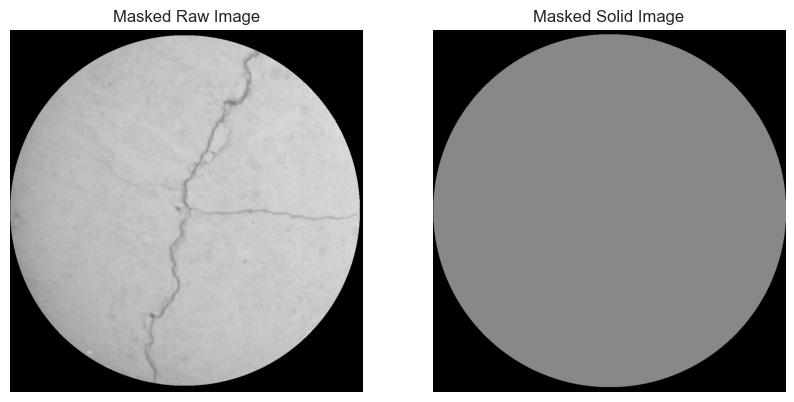


--- Scaling and preprocessing data with robust resizing ---


Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]


--- Verifying final processed tensor ---


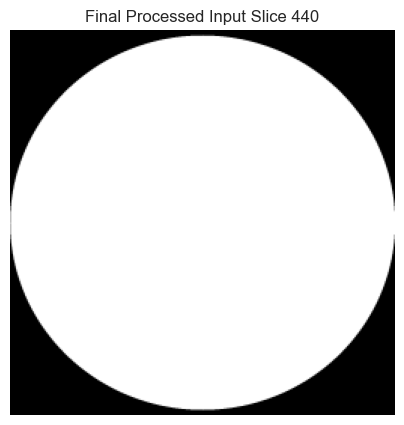


Data pipeline finalized and DataLoaders created successfully!


In [11]:
# Cell 9: Final Data Preparation & Verification

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import torch.nn as nn
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Using OpenCV for robust image resizing

# --- Hyperparameters and Setup ---
DEVICE = "cpu"
IMG_SIZE = 256
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
BETA1 = 0.5
L1_LAMBDA = 100
SAMPLE_SLICE = 440

print(f"Using device: {DEVICE}")

# --- Stage 1: Create Solid Rock Images ---
rock_pixels = raw_images[segmented_images == 0]
rock_value = np.median(rock_pixels) if rock_pixels.size > 0 else np.median(raw_images)
solid_rock_images = np.where(segmented_images > 0, rock_value, raw_images)


# --- Stage 2: Handle Cylindrical Shape by Applying a Circular Mask ---
print("\n--- Applying circular mask to focus on the rock core ---")
# Assuming the raw images are square (height == width)
h, w = raw_images.shape[1], raw_images.shape[2]
# Create a black image and a circle in the center
center_coordinates = (w // 2, h // 2)
radius = w // 2
# Create a 2D boolean mask. True inside the circle, False outside.
Y, X = np.ogrid[:h, :w]
dist_from_center = np.sqrt((X - center_coordinates[0])**2 + (Y-center_coordinates[1])**2)
circular_mask = dist_from_center <= radius

# Apply the mask to all images in the stack
# The [np.newaxis, :, :] adds a new dimension for broadcasting across all 887 slices
solid_rock_images_masked = solid_rock_images * circular_mask[np.newaxis, :, :]
raw_images_masked = raw_images * circular_mask[np.newaxis, :, :]

# --- Verification Plot: Check the masked image ---
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(raw_images_masked[SAMPLE_SLICE], cmap='gray'); ax[0].set_title("Masked Raw Image"); ax[0].axis('off')
ax[1].imshow(solid_rock_images_masked[SAMPLE_SLICE], cmap='gray', vmin=0, vmax=65535); ax[1].set_title("Masked Solid Image"); ax[1].axis('off')
plt.show()


# --- Stage 3: Scale, Clean, and Preprocess Data ---
print("\n--- Scaling and preprocessing data with robust resizing ---")
solid_rock_images_scaled = solid_rock_images_masked.astype(np.float32) / 65535.0
raw_images_scaled = raw_images_masked.astype(np.float32) / 65535.0
solid_rock_images_scaled = np.nan_to_num(solid_rock_images_scaled)
raw_images_scaled = np.nan_to_num(raw_images_scaled)

def preprocess_stack(stack_scaled):
    processed_tensors = []
    for img in tqdm(stack_scaled, desc="Preprocessing images"):
        # --- DEFINITIVE BARCODE FIX: Resize with OpenCV BEFORE converting to tensor ---
        img_resized_np = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
        
        # Now convert the correctly sized NumPy array to a tensor
        img_tensor = to_tensor(img_resized_np)
        
        # Normalize the tensor
        img_normalized = normalize(img_tensor, [0.5], [0.5])
        processed_tensors.append(img_normalized)
    return torch.stack(processed_tensors)

input_tensor = preprocess_stack(solid_rock_images_scaled)
target_tensor = preprocess_stack(raw_images_scaled)

# --- Stage 4: Final Verification of Processed Tensor ---
print("\n--- Verifying final processed tensor ---")
sample_input_tensor = input_tensor[SAMPLE_SLICE].squeeze()
unnormalized_sample = sample_input_tensor.numpy() * 0.5 + 0.5
plt.figure(figsize=(5, 5))
plt.imshow(unnormalized_sample, cmap='gray'); plt.title(f"Final Processed Input Slice {SAMPLE_SLICE}"); plt.axis('off')
plt.show()

# --- Create DataLoaders ---
train_dataset = TensorDataset(input_tensor[100:], target_tensor[100:])
test_dataset = TensorDataset(input_tensor[:100], target_tensor[:100])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("\nData pipeline finalized and DataLoaders created successfully!")

In [12]:
# Cell 10: Model Architecture

class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False, padding_mode="reflect") if down
            else nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_c),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv(x); return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=1, features=64):
        super().__init__()
        self.initial_down=nn.Sequential(nn.Conv2d(in_channels,features,4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        self.down1=UNetBlock(features,features*2,down=True,act="leaky")
        self.down2=UNetBlock(features*2,features*4,down=True,act="leaky")
        self.down3=UNetBlock(features*4,features*8,down=True,act="leaky")
        self.down4=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down5=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down6=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck=nn.Sequential(nn.Conv2d(features*8,features*8,4,2,1),nn.ReLU())
        self.up1=UNetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up3=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up4=UNetBlock(features*16,features*4,down=False,act="relu")
        self.up5=UNetBlock(features*12,features*2,down=False,act="relu")
        self.up6=UNetBlock(features*6,features,down=False,act="relu")
        self.up7=UNetBlock(features*3,features,down=False,act="relu")
        self.final_up=nn.Sequential(nn.ConvTranspose2d(features*2,in_channels,4,2,1),nn.Tanh())
    def forward(self,x):
        d1=self.initial_down(x);d2=self.down1(d1);d3=self.down2(d2);d4=self.down3(d3);d5=self.down4(d4)
        d6=self.down5(d5);d7=self.down6(d6);bottleneck=self.bottleneck(d7)
        up1=self.up1(bottleneck);up2=self.up2(torch.cat([up1,d7],1));up3=self.up3(torch.cat([up2,d6],1))
        up4=self.up4(torch.cat([up3,d5],1));up5=self.up5(torch.cat([up4,d4],1));up6=self.up6(torch.cat([up5,d3],1))
        up7=self.up7(torch.cat([up6,d2],1));return self.final_up(torch.cat([up7,d1],1))

class Discriminator(nn.Module):
    def __init__(self, in_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial=nn.Sequential(nn.Conv2d(in_channels*2,features[0],4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        layers=[];in_channels=features[0]
        for feature in features[1:]:
            layers.append(nn.Sequential(nn.Conv2d(in_channels,feature,4,1 if feature==features[-1] else 2,1,bias=False,padding_mode="reflect"),nn.InstanceNorm2d(feature),nn.LeakyReLU(0.2)))
            in_channels=feature
        layers.append(nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"))
        self.model=nn.Sequential(*layers)
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1);x=self.initial(x);return self.model(x)

print("Models defined successfully.")

Models defined successfully.


--- Starting Generator Warm-up ---


Warm-up Epoch [1/5]:   0%|          | 0/197 [00:00<?, ?it/s]

Warm-up Epoch [2/5]:   0%|          | 0/197 [00:00<?, ?it/s]

Warm-up Epoch [3/5]:   0%|          | 0/197 [00:00<?, ?it/s]

Warm-up Epoch [4/5]:   0%|          | 0/197 [00:00<?, ?it/s]

Warm-up Epoch [5/5]:   0%|          | 0/197 [00:00<?, ?it/s]


--- Starting Full Adversarial Training ---


GAN Epoch [1/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [2/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [3/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [4/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [5/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [6/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [7/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [8/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [9/10]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [10/10]:   0%|          | 0/197 [00:00<?, ?it/s]


--- Training Finished Successfully! ---


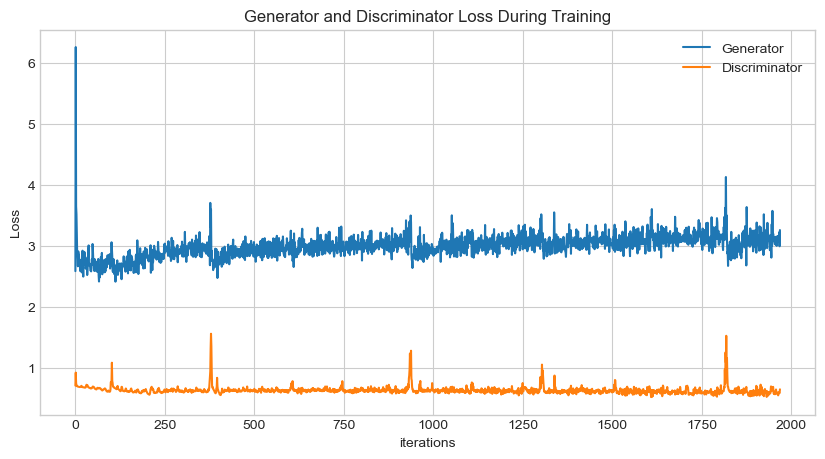

In [15]:
# Cell 11: Full Training Pipeline

# --- 1. Generator Warm-up ---
print("--- Starting Generator Warm-up ---")
gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)
gen_warmup_optim = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
L1 = nn.L1Loss()
WARMUP_EPOCHS = 5 

gen.train()
for epoch in range(WARMUP_EPOCHS):
    loop = tqdm(train_loader, leave=False, desc=f"Warm-up Epoch [{epoch+1}/{WARMUP_EPOCHS}]")
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        y_fake = gen(x); loss = L1(y_fake, y)
        gen_warmup_optim.zero_grad(); loss.backward(); gen_warmup_optim.step()
        loop.set_postfix(L1_Loss=loss.item())

# --- 2. Main Adversarial Training ---
print("\n--- Starting Full Adversarial Training ---")
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
BCE = nn.BCEWithLogitsLoss()
NUM_EPOCHS = 10
os.makedirs("gan_outputs", exist_ok=True)

# Store losses for plotting later
g_losses = []
d_losses = []

for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader, leave=False, desc=f"GAN Epoch [{epoch+1}/{NUM_EPOCHS}]")
    for idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        # Train Discriminator
        y_fake = gen(x)
        D_real=disc(x,y); D_fake=disc(x,y_fake.detach())
        D_loss=(BCE(D_real,torch.ones_like(D_real)) + BCE(D_fake,torch.zeros_like(D_fake)))/2
        disc.zero_grad(); D_loss.backward(); opt_disc.step()
        # Train Generator
        D_fake=disc(x, y_fake)
        G_loss=(BCE(D_fake,torch.ones_like(D_fake))) + L1(y_fake,y)*L1_LAMBDA
        gen.zero_grad(); G_loss.backward(); opt_gen.step()
        # Log losses
        g_losses.append(G_loss.item())
        d_losses.append(D_loss.item())
        loop.set_postfix(D_loss=D_loss.item(),G_loss=G_loss.item())
        
    # Save a sample image each epoch to monitor progress
    gen.eval()
    with torch.no_grad():
        test_input,test_target=next(iter(test_loader)); test_input,test_target=test_input.to(DEVICE),test_target.to(DEVICE)
        gan_output=gen(test_input)
        fig,ax=plt.subplots(1,3,figsize=(15,5)); fig.suptitle(f'Output at Epoch {epoch+1}')
        ax[0].imshow(test_input.squeeze().cpu()*0.5+0.5,cmap='gray'); ax[0].set_title("Input"); ax[0].axis('off')
        ax[1].imshow(gan_output.squeeze().cpu()*0.5+0.5,cmap='gray'); ax[1].set_title("GAN Output"); ax[1].axis('off')
        ax[2].imshow(test_target.squeeze().cpu()*0.5+0.5,cmap='gray'); ax[2].set_title("Ground Truth"); ax[2].axis('off')
        plt.savefig(f"gan_outputs/epoch_{epoch+1}.png"); plt.close(fig)
    gen.train()

print("\n--- Training Finished Successfully! ---")

# --- Plot Training Losses ---
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_losses, label="Generator")
plt.plot(d_losses, label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("gan_outputs/loss_plot.png")
plt.show()

In [16]:
# Cell 9: Final Data Preparation for Guided Generation

import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms.functional import to_tensor, normalize
import torch.nn as nn
import os
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2 # Using OpenCV for robust image resizing

# --- Hyperparameters and Setup ---
DEVICE = "cpu"
IMG_SIZE = 256
BATCH_SIZE = 4
LEARNING_RATE = 2e-4 # Can be slightly higher for this more stable setup
BETA1 = 0.5
L1_LAMBDA = 100
SAMPLE_SLICE = 440

print(f"Using device: {DEVICE}")

# --- Create Solid Rock Images ---
rock_pixels = raw_images[segmented_images == 0]
rock_value = np.median(rock_pixels) if rock_pixels.size > 0 else np.median(raw_images)
solid_rock_images = np.where(segmented_images > 0, rock_value, raw_images)

# --- Apply Circular Mask ---
h, w = raw_images.shape[1], raw_images.shape[2]
center_coordinates = (w // 2, h // 2)
radius = w // 2
Y, X = np.ogrid[:h, :w]
dist_from_center = np.sqrt((X - center_coordinates[0])**2 + (Y-center_coordinates[1])**2)
circular_mask = dist_from_center <= radius

# Apply mask to all three of our source image stacks
solid_rock_images_masked = solid_rock_images * circular_mask[np.newaxis, :, :]
raw_images_masked = raw_images * circular_mask[np.newaxis, :, :]
segmented_images_masked = segmented_images * circular_mask[np.newaxis, :, :] # Also mask the segmentation map

# --- Preprocessing Function ---
def preprocess_stack(stack, is_mask=False):
    processed_tensors = []
    # Masks are usually uint8 with values 0, 1, 2...
    # Images are uint16 with values up to 65535
    scaling_factor = 255.0 if is_mask else 65535.0
    
    for img in tqdm(stack, desc=f"Preprocessing {'masks' if is_mask else 'images'}"):
        img_resized_np = cv2.resize(img.astype(np.float32), (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST if is_mask else cv2.INTER_AREA)
        img_resized_np = img_resized_np / scaling_factor
        img_tensor = to_tensor(img_resized_np)
        img_normalized = normalize(img_tensor, [0.5], [0.5])
        processed_tensors.append(img_normalized)
    return torch.stack(processed_tensors)

# --- Create all three tensors for the guided model ---
input_solid_tensor = preprocess_stack(solid_rock_images_masked, is_mask=False)
input_seg_tensor = preprocess_stack(segmented_images_masked, is_mask=True)
target_real_tensor = preprocess_stack(raw_images_masked, is_mask=False)

# --- Create DataLoaders with three components ---
train_dataset = TensorDataset(input_solid_tensor[100:], input_seg_tensor[100:], target_real_tensor[100:])
test_dataset = TensorDataset(input_solid_tensor[:100], input_seg_tensor[:100], target_real_tensor[:100])
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print("\nData pipeline for guided generation created successfully!")

Using device: cpu


Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]

Preprocessing masks:   0%|          | 0/887 [00:00<?, ?it/s]

Preprocessing images:   0%|          | 0/887 [00:00<?, ?it/s]


Data pipeline for guided generation created successfully!


In [17]:
# Cell 10: Updated Model Architecture

# UNetBlock remains the same
class UNetBlock(nn.Module):
    def __init__(self, in_c, out_c, down=True, act="relu", use_dropout=False):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 4, 2, 1, bias=False, padding_mode="reflect") if down
            else nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(out_c),
            nn.ReLU() if act == "relu" else nn.LeakyReLU(0.2),
        )
        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
    def forward(self, x):
        x = self.conv(x); return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    # --- UPDATE: Takes 2 input channels (solid image + seg map) ---
    def __init__(self, in_channels=2, features=64):
        super().__init__()
        self.initial_down=nn.Sequential(nn.Conv2d(in_channels,features,4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        self.down1=UNetBlock(features,features*2,down=True,act="leaky")
        self.down2=UNetBlock(features*2,features*4,down=True,act="leaky")
        self.down3=UNetBlock(features*4,features*8,down=True,act="leaky")
        self.down4=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down5=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.down6=UNetBlock(features*8,features*8,down=True,act="leaky")
        self.bottleneck=nn.Sequential(nn.Conv2d(features*8,features*8,4,2,1),nn.ReLU())
        self.up1=UNetBlock(features*8,features*8,down=False,act="relu",use_dropout=True)
        self.up2=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up3=UNetBlock(features*16,features*8,down=False,act="relu",use_dropout=True)
        self.up4=UNetBlock(features*16,features*4,down=False,act="relu")
        self.up5=UNetBlock(features*12,features*2,down=False,act="relu")
        self.up6=UNetBlock(features*6,features,down=False,act="relu")
        self.up7=UNetBlock(features*3,features,down=False,act="relu")
        # --- UPDATE: Outputs 1 channel (the final rock image) ---
        self.final_up=nn.Sequential(nn.ConvTranspose2d(features*2,1,4,2,1),nn.Tanh())
    def forward(self,x):
        d1=self.initial_down(x);d2=self.down1(d1);d3=self.down2(d2);d4=self.down3(d3);d5=self.down4(d4)
        d6=self.down5(d5);d7=self.down6(d6);bottleneck=self.bottleneck(d7)
        up1=self.up1(bottleneck);up2=self.up2(torch.cat([up1,d7],1));up3=self.up3(torch.cat([up2,d6],1))
        up4=self.up4(torch.cat([up3,d5],1));up5=self.up5(torch.cat([up4,d4],1));up6=self.up6(torch.cat([up5,d3],1))
        up7=self.up7(torch.cat([up6,d2],1));return self.final_up(torch.cat([up7,d1],1))

class Discriminator(nn.Module):
    # --- UPDATE: Takes a 2-channel condition (x) and 1-channel image (y) ---
    def __init__(self, in_channels_x=2, in_channels_y=1, features=[64, 128, 256, 512]):
        super().__init__()
        total_in_channels = in_channels_x + in_channels_y
        self.initial=nn.Sequential(nn.Conv2d(total_in_channels,features[0],4,2,1,padding_mode="reflect"),nn.LeakyReLU(0.2))
        layers=[];in_channels=features[0]
        for feature in features[1:]:
            layers.append(nn.Sequential(nn.Conv2d(in_channels,feature,4,1 if feature==features[-1] else 2,1,bias=False,padding_mode="reflect"),nn.InstanceNorm2d(feature),nn.LeakyReLU(0.2)))
            in_channels=feature
        layers.append(nn.Conv2d(in_channels,1,4,1,1,padding_mode="reflect"))
        self.model=nn.Sequential(*layers)
    def forward(self,x,y):
        x=torch.cat([x,y],dim=1);x=self.initial(x);return self.model(x)

print("Models for guided generation defined successfully.")

Models for guided generation defined successfully.



--- Starting Guided Adversarial Training ---


GAN Epoch [1/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [2/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [3/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [4/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [5/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [6/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [7/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [8/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [9/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [10/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [11/12]:   0%|          | 0/197 [00:00<?, ?it/s]

GAN Epoch [12/12]:   0%|          | 0/197 [00:00<?, ?it/s]


--- Generating Final Report for Guided GAN---


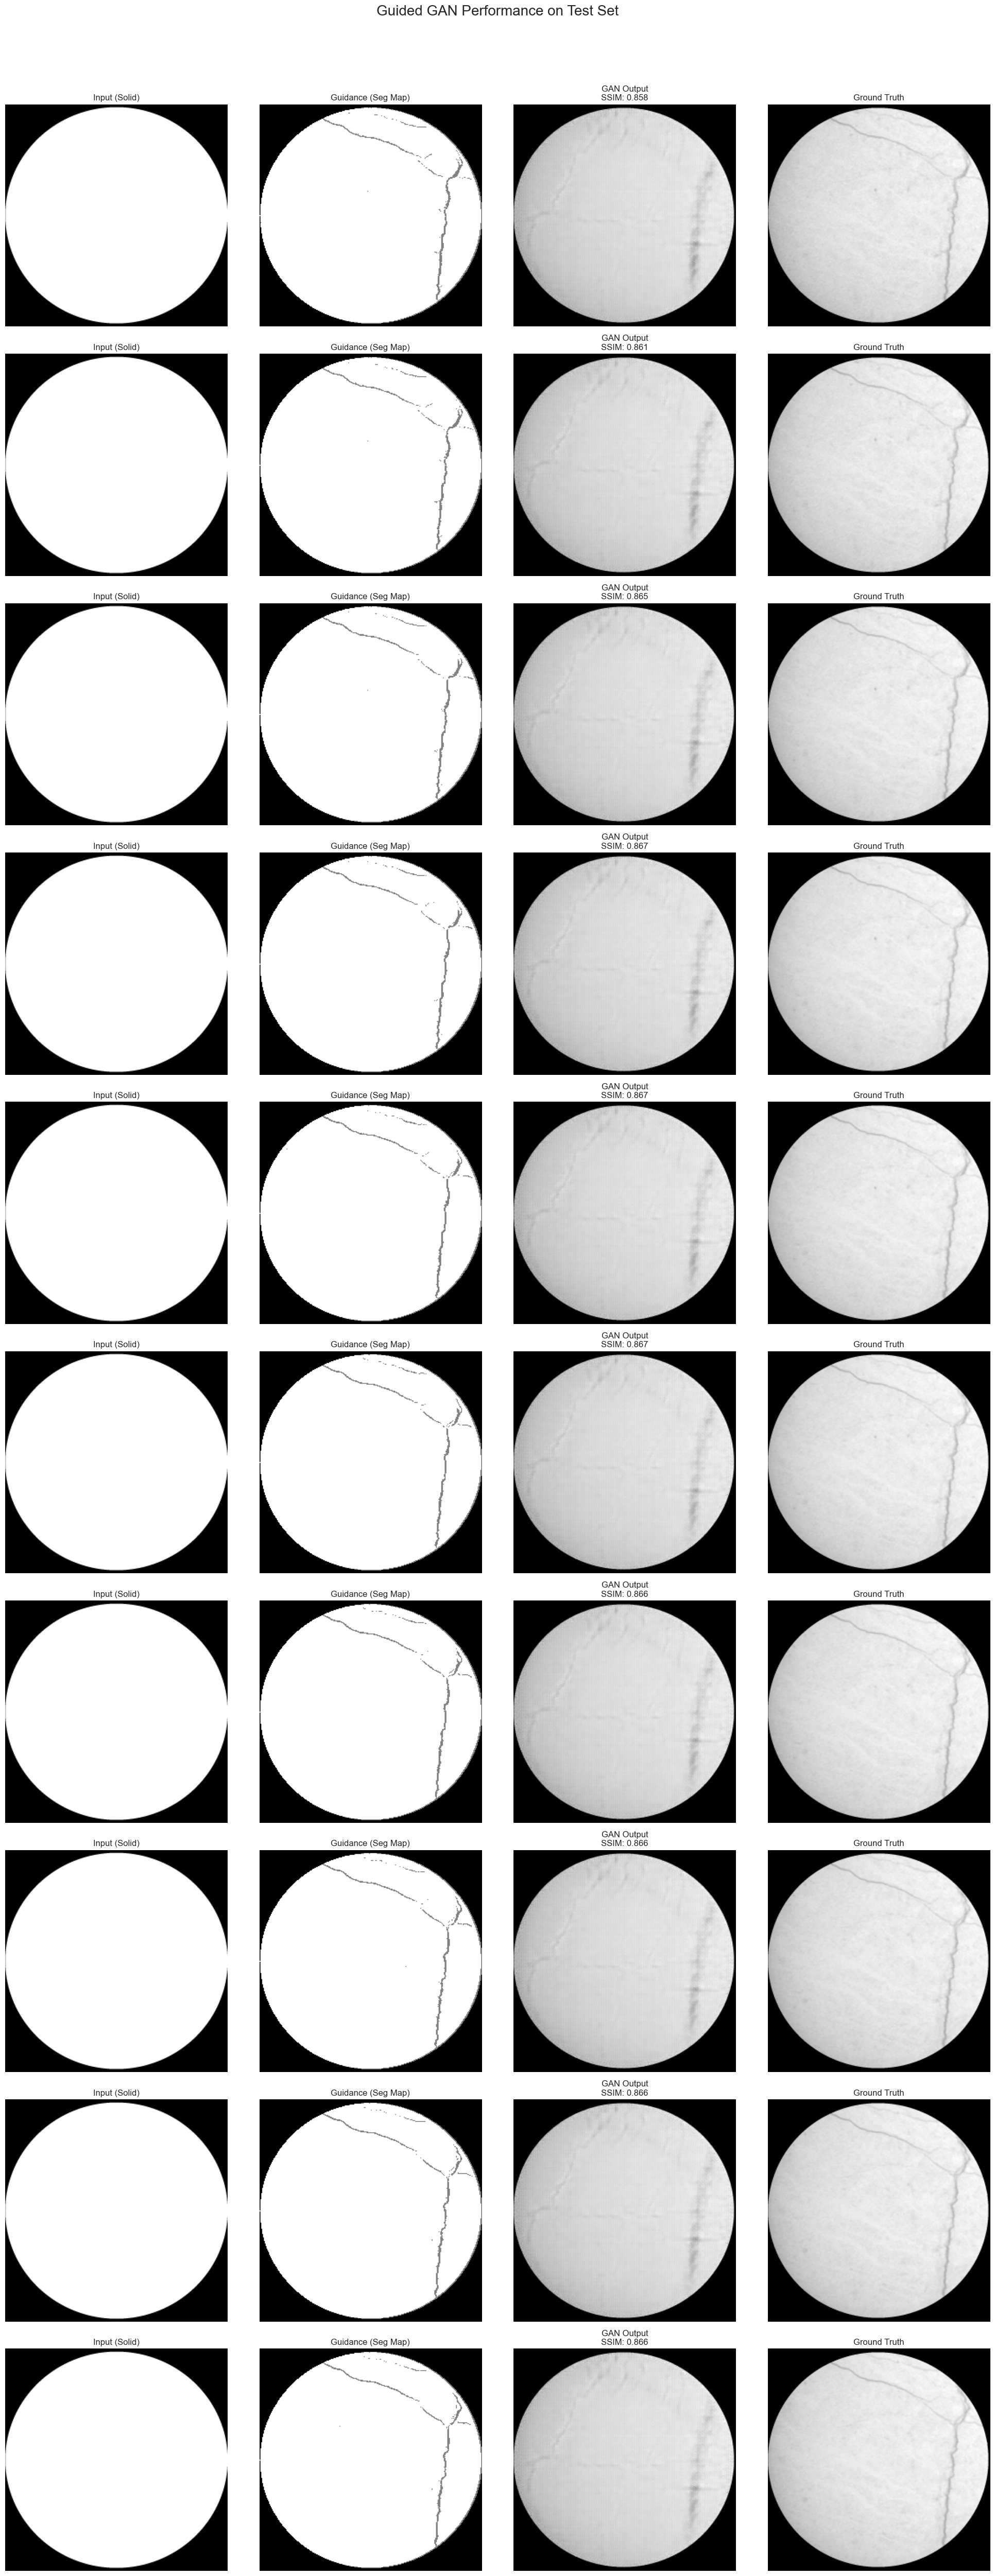


Average SSIM: 0.8650 | Average PSNR: 35.5637 dB

--- Pipeline Finished ---


In [18]:
# Cell 11 & 12: Guided Training and Final Report

# --- Model Initialization ---
gen = Generator().to(DEVICE)
disc = Discriminator().to(DEVICE)
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(BETA1, 0.999))
BCE = nn.BCEWithLogitsLoss()
L1 = nn.L1Loss()
NUM_EPOCHS = 12 # Increased epochs for better quality
os.makedirs("guided_gan_outputs", exist_ok=True)
os.makedirs("guided_final_report", exist_ok=True)

# --- Main Guided Training Loop ---
print("\n--- Starting Guided Adversarial Training ---")
for epoch in range(NUM_EPOCHS):
    loop = tqdm(train_loader, leave=False, desc=f"GAN Epoch [{epoch+1}/{NUM_EPOCHS}]")
    for idx, (x_solid, x_seg, y_true) in enumerate(loop):
        x_solid, x_seg, y_true = x_solid.to(DEVICE), x_seg.to(DEVICE), y_true.to(DEVICE)
        
        # --- UPDATE: Generator input is now a 2-channel tensor ---
        x_condition = torch.cat([x_solid, x_seg], dim=1)
        
        # Train Discriminator
        y_fake = gen(x_condition)
        D_real = disc(x_condition, y_true); D_fake = disc(x_condition, y_fake.detach())
        D_loss = (BCE(D_real, torch.ones_like(D_real)) + BCE(D_fake, torch.zeros_like(D_fake)))/2
        disc.zero_grad(); D_loss.backward(); opt_disc.step()

        # Train Generator
        D_fake = disc(x_condition, y_fake)
        G_loss = BCE(D_fake, torch.ones_like(D_fake)) + L1(y_fake, y_true) * L1_LAMBDA
        gen.zero_grad(); G_loss.backward(); opt_gen.step()
        loop.set_postfix(D_loss=D_loss.item(),G_loss=G_loss.item())

# --- Final Evaluation and Report ---
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr
print("\n--- Generating Final Report for Guided GAN---")
gen.eval()
ssim_scores, psnr_scores = [], []
num_report_images = 10 

fig, axes = plt.subplots(num_report_images, 4, figsize=(20, 5 * num_report_images))
fig.suptitle('Guided GAN Performance on Test Set', fontsize=20, y=1.0)

with torch.no_grad():
    for i, (x_solid, x_seg, y_true) in enumerate(test_loader):
        if i >= num_report_images: break
        x_solid, x_seg, y_true = x_solid.to(DEVICE), x_seg.to(DEVICE), y_true.to(DEVICE)
        
        x_condition = torch.cat([x_solid, x_seg], dim=1)
        y_gan = gen(x_condition)
        
        # Un-normalize images from [-1, 1] to [0, 1]
        img_solid = x_solid[0,0].cpu().numpy()*0.5+0.5
        img_seg = x_seg[0,0].cpu().numpy()*0.5+0.5
        img_true = y_true[0,0].cpu().numpy()*0.5+0.5
        img_gan = y_gan[0,0].cpu().numpy()*0.5+0.5
        
        s=ssim(img_true, img_gan, data_range=1.0); p=psnr(img_true, img_gan, data_range=1.0)
        ssim_scores.append(s); psnr_scores.append(p)
        
        # --- UPDATE: 4-panel plot for enhanced reporting ---
        axes[i, 0].imshow(img_solid, cmap='gray'); axes[i, 0].set_title("Input (Solid)"); axes[i, 0].axis('off')
        axes[i, 1].imshow(img_seg, cmap='gray'); axes[i, 1].set_title("Guidance (Seg Map)"); axes[i, 1].axis('off')
        axes[i, 2].imshow(img_gan, cmap='gray'); axes[i, 2].set_title(f"GAN Output\nSSIM: {s:.3f}"); axes[i, 2].axis('off')
        axes[i, 3].imshow(img_true, cmap='gray'); axes[i, 3].set_title("Ground Truth"); axes[i, 3].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.98]); plt.savefig("guided_final_report/comparison_grid.png"); plt.show()
print(f"\nAverage SSIM: {np.mean(ssim_scores):.4f} | Average PSNR: {np.mean(psnr_scores):.4f} dB")
print("\n--- Pipeline Finished ---")